In [21]:
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer
from scipy.io import loadmat
import yaml

sys.path.append("../")


from models import  FNN_train, compute_2dFourier_bases, compute_2dpca_bases, UnitGaussianNormalizer
from models.Galerkin import GkNN

torch.set_printoptions(precision=16)


torch.manual_seed(0)
np.random.seed(0)


###################################
# load configs
###################################
with open('config.yml', 'r', encoding='utf-8') as f:
    config = yaml.full_load(f)

config = config["FFT_2D"]
config = dict(config)
config_data, config_model, config_train = (
    config["data"],
    config["model"],
    config["train"],
)
downsample_ratio = config_data["downsample_ratio"]
L = config_data["L"]
n_train = config_data["n_train"]
n_test = config_data["n_test"]
device = torch.device(config["train"]["device"])


###################################
# load data
###################################
data_path = "../data/darcy_2d/piececonst_r421_N1024_smooth1"
data = loadmat(data_path)

data_in = data["coeff"]  # shape: 1024,421,421
data_out = data["sol"]  # shape: 1024,421,421
print("data_in.shape:" , data_in.shape)
print("data_out.shape", data_out.shape)

Np_ref = data_in.shape[1]
grid_1d = np.linspace(0, L, Np_ref)
grid_x, grid_y = np.meshgrid(grid_1d, grid_1d)

data_in_ds = data_in[0:n_train, 0::downsample_ratio, 0::downsample_ratio]
grid_x_ds = grid_x[0::downsample_ratio, 0::downsample_ratio]
grid_y_ds = grid_y[0::downsample_ratio, 0::downsample_ratio]
data_out_ds = data_out[0:n_train, 0::downsample_ratio, 0::downsample_ratio]

# x_train, y_train are [n_data, n_x, n_channel] arrays
x_train = torch.from_numpy(
    np.stack(
        (
            data_in_ds,
            np.tile(grid_x_ds, (n_train, 1, 1)),
            np.tile(grid_y_ds, (n_train, 1, 1)),
        ),
        axis=-1,
    ).astype(np.float32)
)
y_train = torch.from_numpy(data_out_ds[:, :, :, np.newaxis].astype(np.float32))
# x_test, y_test are [n_data, n_x, n_channel] arrays
x_test = torch.from_numpy(
    np.stack(
        (
            data_in[-n_test:, 0::downsample_ratio, 0::downsample_ratio],
            np.tile(grid_x[0::downsample_ratio, 0::downsample_ratio], (n_test, 1, 1)),
            np.tile(grid_y[0::downsample_ratio, 0::downsample_ratio], (n_test, 1, 1)),
        ),
        axis=-1,
    ).astype(np.float32)
)
y_test = torch.from_numpy(
    data_out[-n_test:, 0::downsample_ratio, 0::downsample_ratio, np.newaxis].astype(
        np.float32
    )
)

x_train = x_train.reshape(x_train.shape[0], -1, x_train.shape[-1])   # shape: 800,11236,3  (11236 = 106*106 , 106-1 = (421-1) /4)
x_test = x_test.reshape(x_test.shape[0], -1, x_test.shape[-1])
y_train = y_train.reshape(y_train.shape[0], -1, y_train.shape[-1])   # shape: 800,11236,1
y_test = y_test.reshape(y_test.shape[0], -1, y_test.shape[-1])
print("x_train.shape: ",x_train.shape)
print("y_train.shape: ",y_train.shape)

x_normalizer = UnitGaussianNormalizer(x_train, dim=[])
y_normalizer = UnitGaussianNormalizer(y_train, dim=[])
###################################
#compute fourier bases
###################################
k_max = max(config_model["GkNN_modes"])
Np = (Np_ref + downsample_ratio - 1) // downsample_ratio
gridx, gridy, fbases, weights = compute_2dFourier_bases(Np, Np, k_max, L, L)
fbases = fbases.reshape(-1, k_max)
weights = weights.reshape(-1)
wfbases = fbases * np.tile(weights, (k_max, 1)).T
bases_fourier = torch.from_numpy(fbases.astype(np.float32)).to(device)
wbases_fourier = torch.from_numpy(wfbases.astype(np.float32)).to(device)


####################################
#compute pca bases
####################################
k_max = max(config_model["GkNN_modes"])
Np = (Np_ref + downsample_ratio - 1) // downsample_ratio
pca_data = data_out_ds.reshape((data_out_ds.shape[0], -1))
if config_model["pca_include_input"]:
    pca_data = np.vstack(
        (pca_data, data_in_ds.reshape((data_in_ds.shape[0], -1)))
    )
if config_model["pca_include_grid"]:
    n_grid = 1
    pca_data = np.vstack((pca_data, np.tile(grid_x_ds, (n_grid, 1))))
    pca_data = np.vstack((pca_data, np.tile(grid_y_ds, (n_grid, 1))))
print("Start SVD with data shape: ", pca_data.shape)
bases_pca, wbases_pca = compute_2dpca_bases(Np , k_max , L,  pca_data)
bases_pca, wbases_pca = bases_pca.to(device), wbases_pca.to(device)

bases_list = [bases_fourier, wbases_fourier, bases_pca, wbases_pca]



data_in.shape: (1024, 421, 421)
data_out.shape (1024, 421, 421)
x_train.shape:  torch.Size([800, 961, 3])
y_train.shape:  torch.Size([800, 961, 1])
Start SVD with data shape:  (800, 961)


torch.Size([961, 33])


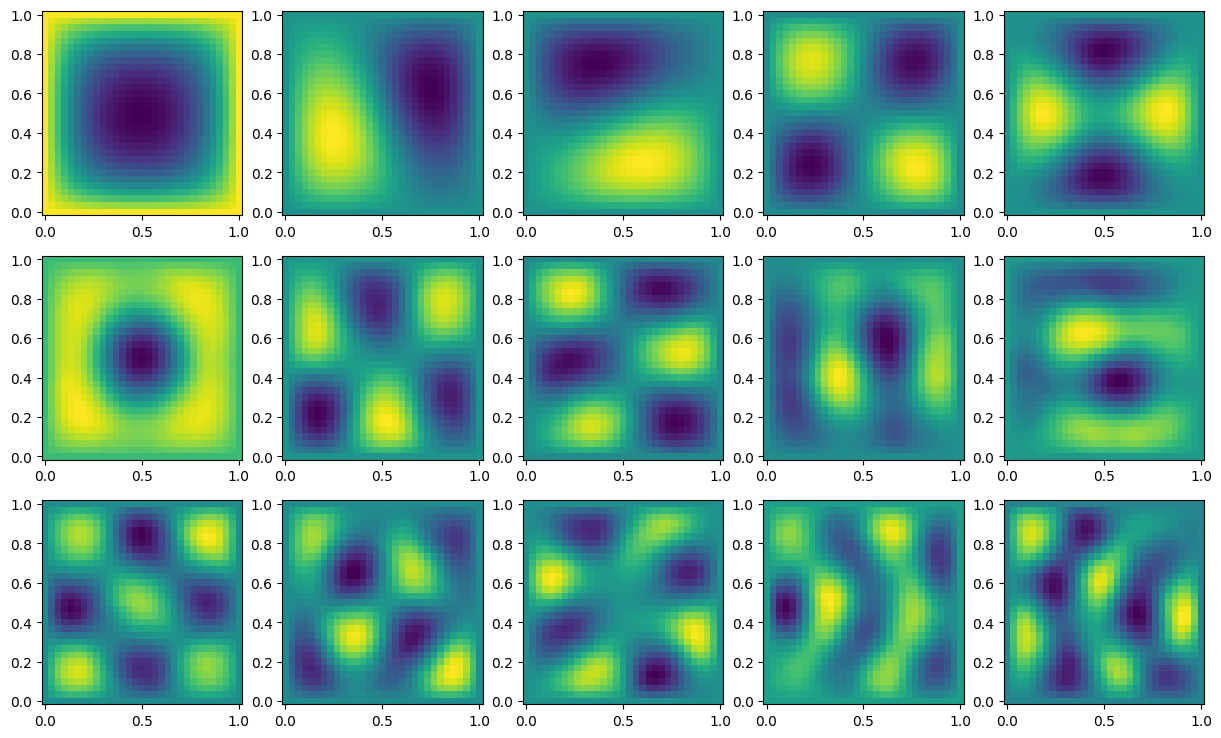

In [23]:
print(bases_pca.shape)
bases_pca_2d = bases_pca.reshape(Np,Np,k_max).to('cpu')
wbases_pca_2d = wbases_pca.reshape(Np,Np,k_max).to('cpu')
bases_fourier_2d = bases_fourier.reshape(Np,Np,k_max).to('cpu')
wbases_fourier_2d = wbases_fourier.reshape(Np,Np,k_max).to('cpu')
mygrid = np.linspace(0, L, Np)
grid_x, grid_y = np.meshgrid(mygrid, mygrid)
m=3
n=5
fig, axs = plt.subplots(m, n, figsize=(3*n,3*m))
for i in range(5):
    axs[0,i].pcolormesh(grid_x, grid_y, bases_pca_2d[:,:,i])
    axs[1,i].pcolormesh(grid_x, grid_y, bases_pca_2d[:,:,i+5])
    axs[2,i].pcolormesh(grid_x, grid_y, bases_pca_2d[:,:,i+10])
    # axs[2,i].pcolormesh(grid_x, grid_y, wbases_pca_2d[:,:,i])
    # axs[3,i].pcolormesh(grid_x, grid_y, bases_fourier_2d[:,:,i])
    # axs[4,i].pcolormesh(grid_x, grid_y, wbases_fourier_2d[:,:,i])

# axs[1].pcolormesh(grid_x, grid_y, data_out[0,:,:])

In [24]:
###################################
#construct model and train
###################################
model = GkNN(bases_list,**config_model).to(device)


print("Start training ", "layer_type: ",config_model["layer_types"])
train_rel_l2_losses, test_rel_l2_losses, test_l2_losses = FNN_train(
    x_train, y_train, x_test, y_test, config, model, save_model_name=False
)

Start training  layer_type:  ['GalerkinConv_pca', 'GalerkinConv_pca', 'GalerkinConv_pca']
Epoch :  0  Rel. Train L2 Loss :  0.16591668799519538  Rel. Test L2 Loss :  0.08763842612504959  Test L2 Loss :  0.0005921542667783797
Epoch :  10  Rel. Train L2 Loss :  0.03115398272871971  Rel. Test L2 Loss :  0.032752972692251206  Test L2 Loss :  0.0002181455143727362
Epoch :  20  Rel. Train L2 Loss :  0.02735249277204275  Rel. Test L2 Loss :  0.03179749965667725  Test L2 Loss :  0.000211035119718872
Epoch :  30  Rel. Train L2 Loss :  0.023163858503103256  Rel. Test L2 Loss :  0.02760835438966751  Test L2 Loss :  0.00018377635162323714
Epoch :  40  Rel. Train L2 Loss :  0.02046722162514925  Rel. Test L2 Loss :  0.026453989371657372  Test L2 Loss :  0.00017597015190403908
Epoch :  50  Rel. Train L2 Loss :  0.01915951881557703  Rel. Test L2 Loss :  0.02640977591276169  Test L2 Loss :  0.00017595683282706887
Epoch :  60  Rel. Train L2 Loss :  0.017572202514857055  Rel. Test L2 Loss :  0.0263264005

C:\Users\15461\AppData\Local\Temp\ipykernel_26244\836109886.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


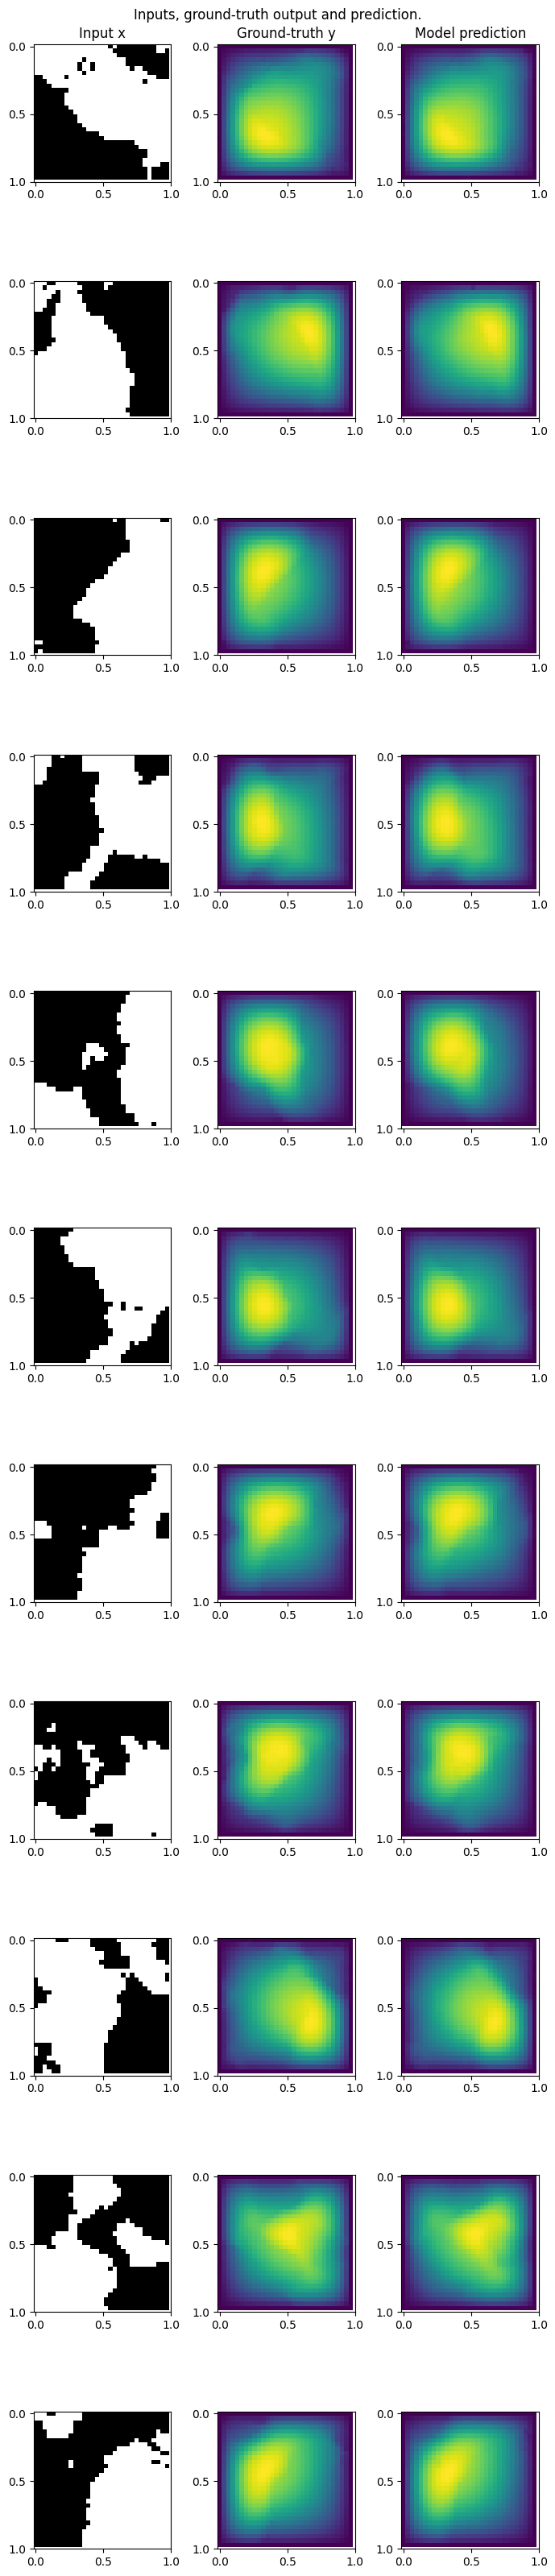

In [25]:
import matplotlib.pyplot as plt
h = 1/Np
n=11
fig = plt.figure(figsize=(7,3*n))

for index in range(n):
    x = x_test[index]
    x = x_normalizer.encode(x).to('cuda')
    y = y_test[index]
    # print(x.shape,y.shape)  #torch.Size([49, 49, 1]) torch.Size([49, 49])

    out = model(x.unsqueeze(0)).to('cpu')
    # print(out.shape)
    out = y_normalizer.decode(out)
    # out = out*(y_normalizer.std+eps)+y_normalizer.mean

    ax = fig.add_subplot(n, 3, index*3 + 1)
    x = x.to('cpu')
    im = ax.imshow(x[:,0].reshape(Np,Np).squeeze(), cmap='gray')
    # # 添加颜色条
    # cbar = plt.colorbar(im, ax=ax)
    # cbar.set_label('Value')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
    plt.yticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
    # plt.xticks([], [])
    # plt.yticks([], [])

    ax = fig.add_subplot(n, 3, index*3 + 2)
    ax.imshow(y.reshape(Np,Np).squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
    plt.yticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
    # plt.xticks([], [])
    # plt.yticks([], [])

    ax = fig.add_subplot(n, 3, index*3 + 3)
    ax.imshow(out.squeeze().reshape(Np,Np).detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
    plt.yticks(np.linspace(0, Np, 3), np.linspace(0, 1, 3))
    # plt.xticks([], [])
    # plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()